## Implementing Densenet for classifying CIFAR-10 objects using Keras 

##### The following code is written & run on google collab notebook with an accuracy of 78.81% on 10k test CIFAR 10 images.
##### The validation accuracy on cifar 10 dataset has been improved over training multiple times by tweaking model architecture, filter count & other hyperparameters.

#### The concepts of Densely connected neural networks(Densenet) can be learnt from [here](https://arxiv.org/pdf/1608.06993.pdf) 

In [2]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

#### Hyperparameters
* Bacth size
* compression rate
* epochs
* dropout rate
* number of filters per block

In [0]:
batch_size = 128
num_classes = 10
epochs = 40
num_filter = 16
compression = 0.5
dropout_rate = 0.2

### CIFAR 10 dataset
CIFAR-10 dataset consists of 60000, 32x32 colour images in 10 classes, with 6000 images per class.
###### There are 50000 training images and 10000 test images.
The ten classes are as: airplane, automobile, bird, deer, dog, cat, horse, frog, ship, truck.

#### Loading CIFAR dataset and Converting train and test  labels to One-hot encoding

In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]


y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 35s 0us/step


(50000, 32, 32, 3) (10000, 32, 32, 3)


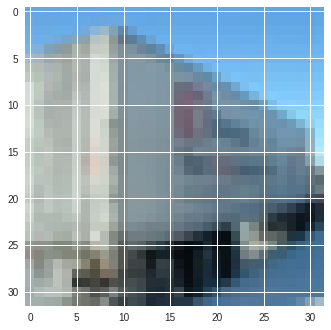

In [75]:
from matplotlib import pyplot as plt
import numpy as np
print(x_train.shape, x_test.shape)

plt.imshow(x_train[15])

### Denseblock function

In [0]:
# Dense Block
def add_denseblock(input, l, num_filter = 16, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_1_1 = Conv2D(int(num_filter*compression),(1,1), use_bias= False, padding='same')(relu)
        BatchNorm = BatchNormalization()(Conv2D_1_1)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

### Transition block, with composite layers of BatchNorm-Activation-BottleneckConv2D1x1-Dropout-2x2Pooling between two dense blocks

In [0]:
def add_transition(input, num_filter = 16, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

### Final Dense layer following global pooling of 2x2

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

### Densenet architecture prior to training, with:
* 1 input layer
* Conv2D with 3x3 kernel
* 4 denseBlock with layer depth l=6,12,16,12 alternatively with transition block
* 3 transition blocks

##### Sequence is as:
#### Input-Conv2D-Denseblock-Transition-Denseblock-Transition-Denseblock-Transition-Denseblock-Output 


In [0]:
num_filter = 16
dropout_rate = 0.2
#l = 12
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros')(input)

First_Block = add_denseblock(First_Conv2D, 6 , num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition,12, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition,16, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,12, num_filter, dropout_rate)
output = output_layer(Last_Block)


### Model summary for above defined densenet architecture

In [56]:
model_2 = Model(inputs=[input], outputs=[output])# model 2 with variable layer depth l=6,12,16,12 as defined above
model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_297 (Conv2D)             (None, 32, 32, 16)   432         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_297 (BatchN (None, 32, 32, 16)   64          conv2d_297[0][0]                 
__________________________________________________________________________________________________
activation_297 (Activation)     (None, 32, 32, 16)   0           batch_normalization_297[0][0]    
__________________________________________________________________________________________________
conv2d_298

conv2d_391 (Conv2D)             (None, 4, 4, 8)      768         activation_390[0][0]             
__________________________________________________________________________________________________
batch_normalization_391 (BatchN (None, 4, 4, 8)      32          conv2d_391[0][0]                 
__________________________________________________________________________________________________
activation_391 (Activation)     (None, 4, 4, 8)      0           batch_normalization_391[0][0]    
__________________________________________________________________________________________________
conv2d_392 (Conv2D)             (None, 4, 4, 8)      576         activation_391[0][0]             
__________________________________________________________________________________________________
dropout_200 (Dropout)           (None, 4, 4, 8)      0           conv2d_392[0][0]                 
__________________________________________________________________________________________________
concatenat

#### Saving model architectures as json string

In [0]:
configuration_1 = model.get_config()# configuration of model_1 with constant value l=12 through 4 dense blocks
configuration_2 = model_2.get_config()# model_2 configuration with var value of l through 4 dense blocks

In [40]:
from keras.models import model_from_json
json_model1= model.to_json()# saving model_1 architecture with constant value of l=12 through 4 dense blocks
json_model2= model_2.to_json()#saving model_2 with variable value of l=6,12,16,12 through 4 dense blocks
print('model 1: \n',json_model1,'\n model 2 \n', json_model2)

model 1: 
 {"class_name": "Model", "config": {"name": "model_1", "layers": [{"name": "input_1", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 32, 32, 3], "dtype": "float32", "sparse": false, "name": "input_1"}, "inbound_nodes": []}, {"name": "conv2d_1", "class_name": "Conv2D", "config": {"name": "conv2d_1", "trainable": true, "filters": 16, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "linear", "use_bias": false, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"name": "batch_normalization_1", "class_name": "BatchNormalization", "config": {"name": "b

### Model Compilation: defining loss function, preferred optimizer fucntion

In [0]:
model_2.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

### Model training, using 50k training images as x_train & labels y_train with batch_size 128, 40 epochs

In [62]:
model_2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 193s 4ms/step - loss: 2.0226 - acc: 0.2500 - val_loss: 2.1541 - val_acc: 0.2873
Epoch 2/40
19200/50000 [==========>...................] - ETA: 1:36 - loss: 1.7060 - acc: 0.368650000/50000 [==============================] - 164s 3ms/step - loss: 1.6617 - acc: 0.3860 - val_loss: 1.6439 - val_acc: 0.4168
Epoch 3/40
45568/50000 [==========================>...] - ETA: 13s - loss: 1.5175 - acc: 0.439850000/50000 [==============================] - 164s 3ms/step - loss: 1.5113 - acc: 0.4420 - val_loss: 1.6273 - val_acc: 0.4444
Epoch 4/40
50000/50000 [==============================] - 164s 3ms/step - loss: 1.4049 - acc: 0.4842 - val_loss: 1.4780 - val_acc: 0.4781
Epoch 5/40
 3328/50000 [>.............................] - ETA: 2:27 - loss: 1.3458 - acc: 0.496450000/50000 [==============================] - 164s 3ms/step - loss: 1.3138 - acc: 0.5182 - val_loss: 1.3909 - val_acc: 0.5137
Epoch 

### Model accuracy evaluation, on 10k test images

In [70]:
# Testing model on 10k test images
score = model_2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 32s 3ms/step
Test loss: 0.6428350119113923
Test accuracy: 0.7881


#### Saving learned weights to local disk

In [72]:
# Save the trained weights in to .h5 format
model_2.save_weights("DNST_model_2.h5")
print("Saved model to disk")

Saved model to disk


In [77]:
!ls

datalab  DNST_model_2.h5


In [0]:
from google.colab import files

files.download('DNST_model_2.h5')